## A ejecutar

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K
from itertools import chain
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from keras.regularizers import l2

from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Bidirectional, LSTM, Reshape, RepeatVector, TimeDistributed
from keras.layers import BatchNormalization, Activation
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

def x_and_y(df_desc_final_pickle, num_steps = 10, index = False):
    x, y, quantiles_final, new_values = [], [], [], []

    for i in range(1, 9):
        if index:
            batery_df = df_desc_final_pickle[df_desc_final_pickle.cell == i]
            quantiles = []
            for j in range(1, len(batery_df) - num_steps):
                x.append(np.array(batery_df.iloc[slice(j,num_steps+j), 1:].drop(columns=['RUL']).values))
                y.append(np.array([batery_df.iloc[slice(j,num_steps+j), 1:].RUL.values[-1], i]))
                quantiles.append(i)
        else:
            batery_df = df_desc_final_pickle[df_desc_final_pickle.index.get_level_values(0) == i]
            batery_df.index = pd.MultiIndex.from_tuples([(1, x) for x in range(1, batery_df.shape[0] + 1)])
            quantiles = []
            for j in range(1, len(batery_df) - num_steps):

                x.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].drop(columns=['RUL']).values))
                y.append(np.array([batery_df.loc[(1, slice(j,num_steps+j)), :].RUL.values[-1], i]))
                quantiles.append(i)

        quantiles_final.append(np.array_split(range(len(quantiles)), 4))
            
    x, y = np.array(x), np.array(y)

    for j in np.unique(y[:,1]):
        batery_column = y[:,1][y[:,1] == j]
        new_values.append([i+1 for i in range(4) for x in batery_column[quantiles_final[int(j-1)][i]].tolist()])
    y = np.append(y, np.array(list(chain(*new_values))).reshape(-1,1), axis = 1)
    y[:,0] = y[:,0].astype(float)
    print(x.shape, y.shape)
    return x, y

def scatter_cycle_plot(df_desc_final_pickle_load, battery, ypred, y_test, y_test_mod, index = False):

    differences = (y_test - ypred).flatten()
    list_soh = []
    for k, v in enumerate(differences):
        if y_test_mod[:,1][k] == battery:
            df_modify = df_desc_final_pickle_load.loc[y_test_mod[:,1][k],:]
            yellow = df_modify.head(1).RUL[0] - df_modify[df_modify['SoH_max_ch']>=81].tail(1).index.get_level_values(0)[0]
            red = df_modify.RUL.min() if len(df_modify[df_modify['SoH_max_ch']<70].head(1)) == 0 else df_modify[df_modify['SoH_max_ch']<70].head(1).RUL.values[0]
            list_soh.append(v)

    plt.scatter(range(len(list_soh)), np.sort(list_soh), s = 110, color='k')
    plt.xticks(fontsize=22, family='serif'), plt.yticks(fontsize=22, family='serif');
    plt.grid(linestyle='--',linewidth=1.5, alpha = 0.4);
    plt.xlabel('Instances', fontsize=24, family='serif'), plt.ylabel('Cycle error', fontsize=24, family='serif'), plt.title(f'Prediction cell {battery}', fontsize=24, fontweight='bold', family='serif');

    yellow_lim = np.max(list_soh) + 50 if np.max(list_soh) > yellow else 100
    red_lim = np.min(list_soh) - 100 if np.min(list_soh) < 50 else 100
    annotation = abs((yellow + yellow_lim) - (red+red_lim)) / 40

    plt.axhspan(red, red+red_lim, facecolor='#f50400', alpha=0.3), plt.axhspan(yellow + yellow_lim, yellow, facecolor='#f4b41a', alpha=0.4), \
                                                                   plt.axhspan(yellow, 0, facecolor='#68da3e', alpha=0.4), plt.axhspan(0, red, facecolor='#f4b41a', alpha=0.4);
    for k,v in enumerate(np.sort(list_soh)): 
        if int(np.round(v)) < 0: plt.annotate( str(int(np.round(v))), (k, v + annotation), fontsize=18, color = 'r', fontweight='bold', rotation=90)
        else: plt.annotate( str(int(np.round(v))), (k, v + annotation), fontsize=18, color = 'k', fontweight='bold',rotation=90);
    plt.ylim(red+red_lim, yellow + yellow_lim);
    for text in plt.gca().get_legend().get_texts():
        plt.setp(text, family='serif')

def scatter_plot_prediction(ypred, y_test, y_test_mod):
    fig = plt.figure(figsize=(50, 20))
    for x in range(1, 9):
        plt.subplot(2, 4, x)
        scatter_cycle_plot(df_desc_final_pickle_load, x, ypred, y_test, y_test_mod, False)

def line_plot_result(ypred, y_test, title):
    ypred_ordered = ypred[np.argsort(y_test, axis=0)]
    y_test_ordered = np.sort(y_test, axis=0)

    plt.plot(y_test_ordered,  label='Real', color='#E76F51', linewidth=3);
    plt.plot(ypred_ordered.reshape(-1,1), 'bo',label='Prediction', color='#264653', linewidth=1);
    plt.xticks(fontsize=16, family='serif'), plt.yticks(fontsize=16, family='serif'), plt.grid(linestyle='--',linewidth=1.5, alpha = 0.5);
    plt.xlabel('Instances', fontsize=16, family='serif'), plt.ylabel('Cycles', fontsize=16, family='serif'), plt.title('Model results' + title, fontsize=16, fontweight='bold', family='serif');
    plt.legend(fontsize=16);
    for text in plt.gca().get_legend().get_texts():
        plt.setp(text, family='serif')

def bar_plot_comparison(nombres, list_red, list_yellow, list_green):
    X_axis = np.arange(len(nombres))
    fig1, ax1 = plt.subplots(figsize=(20, 5))
    plt.bar(X_axis - 0.2, list_red, 0.2, color = '#f50400', label = 'Dangerous', alpha = 0.3)
    plt.bar(X_axis, list_yellow, 0.2, color = '#f4b41a', label = 'Aceptable', alpha = 0.3)
    plt.bar(X_axis + 0.2, list_green, 0.2, color = '#68da3e', label = 'Excelent', alpha = 0.3)
    plt.xticks(X_axis, nombres, fontsize = 15, family='serif'), plt.yticks(fontsize = 15, family='serif');
    plt.xlabel("Models", color = 'k',fontsize=15, family='serif'), plt.ylabel("% of bateries", color = 'k',  fontsize=15, family='serif')
    plt.title("Model results", color = 'k', weight = 'bold', fontsize=18, family='serif')
    plt.ylim(0, 100)
    for p in ax1.patches: plt.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=14, weight = 'bold')

def green_yellow_red(ypred, y_test, y_test_mod):
    differences = (y_test - ypred).flatten()
    red_list, yellow_list, green_list = [], [], []
    for k, v in enumerate(differences):
        df_modify = df_desc_final_pickle_load[df_desc_final_pickle_load.index.get_level_values(0) == y_test_mod[k][1]]
        yellow = df_modify.head(1).RUL.values[0] - df_modify[df_modify['SoH_max_ch']>=81].tail(1).index.get_level_values(1)[0]
        red = df_modify.RUL.min() if len(df_modify[df_modify['SoH_max_ch']<70].head(1)) == 0 else df_modify[df_modify['SoH_max_ch']<70].head(1).RUL.values[0]
        if (v <= yellow) & (v >= 0): green_list.append(k)
        if (v <= red): red_list.append(k)
        if ((v > red) & (v < 0)) | (v > yellow) : yellow_list.append(k)
    sum_list = len(red_list) + len(yellow_list) + len(green_list)
    return 100*(len(green_list)/sum_list), 100*len(yellow_list)/sum_list, 100*len(red_list)/sum_list
    
def customLoss(true,pred):
    diff = pred - true
    greater = K.greater(diff,0)
    greater = K.cast(greater, K.floatx()) 
    greater = greater + 1                
    return K.mean(K.square(diff))*greater
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [2]:
path_origin, path_processed = "../data/original_data/", "../data/processed_data/"
models_path, models_path_normal = "../data/processed_data/gans_models/", "../data/processed_data/models/"
palette = ['#264653','#2A9D8F','#85CAC2','#DFF6F4' ,'#E9C46A','#F4A261','#E76F51','#C53D1B', '#7E2711']
cells = [f'\Cell{x}\*' for x in range(1, 9)]
font = {'size': 16, 'color': 'black', 'weight': 'bold'}

In [3]:
df_desc_final_pickle_load = pd.read_pickle(path_processed + 'df_desc_final.pkl')
df_desc_final_pickle = df_desc_final_pickle_load[df_desc_final_pickle_load.RUL >= 0 ]
df_desc_final_pickle["RUL"] = df_desc_final_pickle["RUL"].astype(float)
print(df_desc_final_pickle.shape)

(390, 41)


In [4]:
X_train, num_steps, quantiles_final = [], 10, []
for i in [1,2,3,4,5,6,7,8]:
    batery_df = df_desc_final_pickle[df_desc_final_pickle.index.get_level_values(0) == i]
    batery_df.index = pd.MultiIndex.from_tuples([(1, x) for x in range(1, batery_df.shape[0] + 1)])
    quantiles = []
    for j in range(1, len(batery_df) - num_steps):

        X_train.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].values))
        
X_train = np.array(X_train)
X_train = np.stack(X_train, axis=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

In [5]:
x, y, X_test, y_test, X_val, y_val = [], [], [], [], [], []

for i in range(1,9):
    batery_df = df_desc_final_pickle[df_desc_final_pickle.index.get_level_values(0) == i]
    batery_df.index = pd.MultiIndex.from_tuples([(1, x) for x in range(1, batery_df.shape[0] + 1)])
    quantiles = []
    if i == 6:
        for j in range(1, len(batery_df) - num_steps):
            X_test.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].drop(columns=['RUL']).values))
            y_test.append(np.array([batery_df.loc[(1, slice(j,num_steps+j)), :].RUL.values[-1]]))

    # if (i in [4, 8, 7]):
    if (i in [4, 8, 6]):
    # if (i in [6]):
        for j in range(1, len(batery_df) - num_steps):
            X_val.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].drop(columns=['RUL']).values))
            y_val.append(np.array([batery_df.loc[(1, slice(j,num_steps+j)), :].RUL.values[-1]]))

    else:
        for j in range(1, len(batery_df) - num_steps):
            x.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].drop(columns=['RUL']).values))
            y.append(np.array([batery_df.loc[(1, slice(j,num_steps+j)), :].RUL.values[-1]]))
        
X_train, y_train, X_test, y_test, X_val, y_val = np.array(x), np.array(y), np.array(X_test), np.array(y_test), np.array(X_val), np.array(y_val)
y_train[:,0], y_test[:,0], y_val[:, 0] = y_train[:,0].astype(float), y_test[:,0].astype(float), y_val[:,0].astype(float)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((200, 11, 40), (200, 1), (33, 11, 40), (33, 1), (102, 11, 40), (102, 1))

In [6]:
batch_size = 128
random = np.random.normal(0, 1, (batch_size, X_train.shape[1], 41))
from keras.models import load_model
gan_model = load_model(models_path + "LSTM_generator_3000_good.h5")
X_train_augmented = gan_model.predict(random)
X_train_augmented = scaler.inverse_transform(X_train_augmented.reshape(-1, X_train_augmented.shape[-1])).reshape(X_train_augmented.shape)

4/4 [==============================] - 4s 23ms/step


In [7]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_train_augmented = scaler.transform(X_train_augmented[:,:,:-1].reshape(-1, X_train_augmented[:,:,:-1].shape[-1])).reshape(X_train_augmented[:,:,:-1].shape)

new_X_train, new_y_train = np.concatenate((X_train, X_train_augmented), axis = 0), np.concatenate((y_train, X_train_augmented[:,:,-1][:,-1].reshape(-1,1)), axis = 0)

X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

new_X_train.shape, new_y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((328, 11, 40), (328, 1), (102, 11, 40), (102, 1), (33, 11, 40), (33, 1))

## **JONAME**
---

In [ ]:
model = keras.models.load_model(models_path_normal + f'first_model_Bidirectional_LSTM_good_adapted.h5', custom_objects={'customLoss': customLoss})

early_stopping = keras.callbacks.EarlyStopping(patience=2000, restore_best_weights=True)
checkpoint_new = keras.callbacks.ModelCheckpoint(models_path +'JONAME.h5', verbose = 0, save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=100, factor=0.8, min_lr=0.00001)

model.trainable = False

np.random.seed(10), tf.random.set_seed(10);

reshape = keras.layers.Reshape((1040, 1))(model.layers[-2].output)
new_batch = keras.layers.BatchNormalization()(reshape)
new_GRU = keras.layers.LSTM(12, dropout=0.35, recurrent_dropout=0.35)(new_batch)
new_output = keras.layers.Dense(1, activation='relu', name='new_output')(new_GRU)
new_model = keras.Model(inputs=model.inputs, outputs=new_output)
new_model.summary()

opt = keras.optimizers.Adam(lr=0.01, beta_1=0.5)
new_model.compile(optimizer=opt, loss=customLoss, metrics = 'mae')
historyBiLSTM = new_model.fit(new_X_train, new_y_train, epochs=10000, batch_size=16, validation_data = (X_val, y_val), verbose=1, shuffle=True, callbacks=[early_stopping, checkpoint_new, reduce_lr])

## **DANI**
---

In [8]:
lr = 0.0005
count = 1
while lr > 0.00001:
    lr = lr * 0.9
    count += 1

In [10]:
count * 200

7800

In [9]:
model = keras.models.load_model(models_path_normal + f'first_model_Bidirectional_LSTM_good_adapted.h5', custom_objects={'customLoss': customLoss})

early_stopping = keras.callbacks.EarlyStopping(patience=5000, restore_best_weights=True)
checkpoint_new = keras.callbacks.ModelCheckpoint(models_path +'DANI8_LSTM.h5', verbose = 0, save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=200, factor=0.9, min_lr=0.00001)

model.trainable = False

np.random.seed(73), tf.random.set_seed(73);

new_activation = keras.layers.LeakyReLU(alpha=0.2)(model.layers[-2].output)
new_dropout = keras.layers.Dropout(0.35)(new_activation)
new_output = keras.layers.Dense(1, activation='relu', name='new_output')(new_dropout)
new_model = keras.Model(inputs=model.inputs, outputs=new_output)

opt = keras.optimizers.Adam(lr=0.0005, beta_1=0.5)
new_model.compile(optimizer=opt, loss=customLoss, metrics = 'mae')
historyBiLSTM = new_model.fit(new_X_train, new_y_train, epochs=15000, batch_size=16, validation_data = (X_val, y_val), verbose=1, shuffle=True, callbacks=[checkpoint_new, reduce_lr])

Epoch 1/15000
21/21 [==============================] - 6s 148ms/step - loss: 5033526.0000 - mae: 1325.0665 - val_loss: 3010617.5000 - val_mae: 1492.9448 - lr: 5.0000e-04
Epoch 2/15000
21/21 [==============================] - 1s 56ms/step - loss: 3075825.2500 - mae: 1142.3934 - val_loss: 1866114.5000 - val_mae: 1177.6085 - lr: 5.0000e-04
Epoch 3/15000
21/21 [==============================] - 1s 52ms/step - loss: 2011773.5000 - mae: 991.2928 - val_loss: 1130918.5000 - val_mae: 919.3698 - lr: 5.0000e-04
Epoch 4/15000
21/21 [==============================] - 1s 50ms/step - loss: 1403940.2500 - mae: 887.6707 - val_loss: 691827.8125 - val_mae: 721.9167 - lr: 5.0000e-04
Epoch 5/15000
21/21 [==============================] - 1s 56ms/step - loss: 1093521.5000 - mae: 805.7636 - val_loss: 429130.6562 - val_mae: 567.7411 - lr: 5.0000e-04
Epoch 6/15000
21/21 [==============================] - 1s 47ms/step - loss: 868876.3750 - mae: 717.4052 - val_loss: 265613.4375 - val_mae: 450.0837 - lr: 5.0000e-

## **CUMPLO**
---

In [21]:
model = keras.models.load_model(models_path_normal + f'tryals_bidirectional_lstm_24.h5', custom_objects={'customLoss': customLoss})

early_stopping = keras.callbacks.EarlyStopping(patience=1000, restore_best_weights=True)
checkpoint_new = keras.callbacks.ModelCheckpoint(models_path +'CUMPLO.h5', verbose = 0, save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=100, factor=0.8, min_lr=0.00001)

model.trainable = False

np.random.seed(7), tf.random.set_seed(7);

reshape = keras.layers.Reshape((1248, 1))(model.layers[-2].output)
new_batch = keras.layers.BatchNormalization()(reshape)
new_GRU = keras.layers.LSTM(12, dropout=0.25, recurrent_dropout=0.25)(new_batch)
new_output = keras.layers.Dense(1, activation='relu', name='new_output')(new_GRU)
new_model = keras.Model(inputs=model.inputs, outputs=new_output)

opt = keras.optimizers.Adam(lr=0.01)
new_model.compile(optimizer=opt, loss=customLoss, metrics = 'mae')
historyBiLSTM = new_model.fit(new_X_train, new_y_train, epochs=10000, batch_size=32, validation_data = (X_val, y_val), verbose=1, shuffle=True, callbacks=[early_stopping, checkpoint_new, reduce_lr])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_24_input (Inp  [(None, 11, 40)]         0         
 utLayer)                                                        
                                                                 
 bidirectional_24 (Bidirecti  (None, 1248)             3666208   
 onal)                                                           
                                                                 
 reshape_2 (Reshape)         (None, 1248, 1)           0         
                                                                 
 batch_normalization_2 (Batc  (None, 1248, 1)          4         
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 12)                672       
                                                           

KeyboardInterrupt: 

## **AITOR**
---

In [23]:
model = keras.models.load_model(models_path_normal + f'first_model_Bidirectional_LSTM_good_adapted.h5', custom_objects={'customLoss': customLoss})

early_stopping = keras.callbacks.EarlyStopping(patience=5000, restore_best_weights=True)
checkpoint_new = keras.callbacks.ModelCheckpoint(models_path +'HHHH.h5', verbose = 1, save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=200, factor=0.9, min_lr=0.00001)

model.trainable = False

np.random.seed(2), tf.random.set_seed(2);

new_activation = keras.layers.LeakyReLU(alpha=0.2)(model.layers[-2].output)
new_dropout = keras.layers.Dropout(0.35)(new_activation)
new_output = keras.layers.Dense(1, activation='relu', name='new_output')(new_dropout)
new_model = keras.Model(inputs=model.inputs, outputs=new_output)

opt = keras.optimizers.Nadam(lr=0.0005, beta_1=0.5)
new_model.compile(optimizer=opt, loss=customLoss, metrics = 'mae')
historyBiLSTM = new_model.fit(new_X_train, new_y_train, epochs=25000, batch_size=16, validation_data = (X_val, y_val), verbose=1, shuffle=True, callbacks=[early_stopping, checkpoint_new, reduce_lr])

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_input (InputL  [(None, 11, 40)]         0         
 ayer)                                                           
                                                                 
 bidirectional (Bidirectiona  (None, 1040)             2420704   
 l)                                                              
                                                                 
 reshape_8 (Reshape)         (None, 1040, 1)           0         
                                                                 
 batch_normalization_8 (Batc  (None, 1040, 1)          4         
 hNormalization)                                                 
                                                                 
 lstm_8 (LSTM)               (None, 12)                672       
                                                           

KeyboardInterrupt: 

## **UGARTE**
---

In [10]:
model = keras.models.load_model(models_path_normal + f'first_model_Bidirectional_LSTM_good_adapted.h5', custom_objects={'customLoss': customLoss})

early_stopping = keras.callbacks.EarlyStopping(patience=5000, restore_best_weights=True)
checkpoint_new = keras.callbacks.ModelCheckpoint(models_path +'UGART_LAST_DANCE.h5', verbose = 1, save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=200, factor=0.9, min_lr=0.00001)

model.trainable = False

np.random.seed(1), tf.random.set_seed(1);

new_activation = keras.layers.LeakyReLU(alpha=0.2)(model.layers[-2].output)
new_dropout = keras.layers.Dropout(0.35)(new_activation)
new_output = keras.layers.Dense(1, activation='relu', name='new_output')(new_dropout)
new_model = keras.Model(inputs=model.inputs, outputs=new_output)

opt = keras.optimizers.Adam(lr=0.0005, beta_1=0.5)
new_model.compile(optimizer=opt, loss=customLoss, metrics = 'mae')
historyBiLSTM = new_model.fit(new_X_train, new_y_train, epochs=25000, batch_size=16, validation_data = (X_val, y_val), verbose=1, shuffle=True, callbacks=[early_stopping, checkpoint_new, reduce_lr])

Epoch 1/25000
18/18 [==============================] - 8s 235ms/step - loss: 3204004.7500 - mae: 1148.0189 - val_loss: 8375371.0000 - val_mae: 2445.4875 - lr: 0.0500
Epoch 2/25000
18/18 [==============================] - 1s 54ms/step - loss: 3199786.2500 - mae: 1148.1171 - val_loss: 8352285.5000 - val_mae: 2441.6499 - lr: 0.0500
Epoch 3/25000
18/18 [==============================] - 1s 50ms/step - loss: 3193312.0000 - mae: 1148.4141 - val_loss: 8319635.0000 - val_mae: 2436.1160 - lr: 0.0500
Epoch 4/25000
18/18 [==============================] - 1s 49ms/step - loss: 3183145.5000 - mae: 1148.6165 - val_loss: 8279661.5000 - val_mae: 2429.0916 - lr: 0.0500
Epoch 5/25000
18/18 [==============================] - 1s 49ms/step - loss: 3169049.7500 - mae: 1148.6573 - val_loss: 8230708.0000 - val_mae: 2420.3547 - lr: 0.0500
Epoch 6/25000
18/18 [==============================] - 1s 48ms/step - loss: 3151372.5000 - mae: 1148.5808 - val_loss: 8173065.0000 - val_mae: 2409.9395 - lr: 0.0500
Epoch 7/2

KeyboardInterrupt: 

# **RESULTS**

In [8]:
model = load_model(models_path + "DANI5.h5", custom_objects={'customLoss': customLoss})

def customLoss_numpy(true,pred):
    diff = pred - true
    greater = np.max(diff, 0)
    greater = greater + 1     
    return np.mean(greater*diff**2)

ypred = model.predict(X_test)
print('Test -->', r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred)), customLoss_numpy(y_test, ypred))

2/2 [==============================] - 0s 31ms/step
Test --> 0.9407555208324171 232.66902935143673 253.09257000332838 20141576.65570788


In [9]:
ypred = model.predict(X_test)
print('Test -->', r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred)), customLoss_numpy(y_test, ypred))
ypred_train = model.predict(X_train)
print('Train -->', r2_score(y_train, ypred_train), mean_absolute_error(y_train, ypred_train), np.sqrt(mean_squared_error(y_train, ypred_train)), customLoss_numpy(y_train, ypred_train))

2/2 [==============================] - 0s 32ms/step
Test --> 0.9649180868764935 170.52833776762992 194.75879878569236 13043796.8994823
9/9 [==============================] - 1s 62ms/step
Train --> 0.974157271159473 191.89106753324486 219.6480158694199 15574417.399346072


In [14]:
ypred = model.predict(X_test)
print('Test -->', r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred)), customLoss_numpy(y_test, ypred))
ypred_train = model.predict(X_train)
print('Train -->', r2_score(y_train, ypred_train), mean_absolute_error(y_train, ypred_train), np.sqrt(mean_squared_error(y_train, ypred_train)), customLoss_numpy(y_train, ypred_train))

2/2 [==============================] - 0s 20ms/step
Test --> 0.9590569251164631 181.23175950483844 210.39997348805838 84084.55765222872
9/9 [==============================] - 0s 46ms/step
Train --> 0.9561546952361111 253.16445347101714 286.10117785904873 3401732.3108659084


In [9]:
ypred = model.predict(X_test)
print('Test -->', r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred)), customLoss_numpy(y_test, ypred))
ypred_train = model.predict(X_train)
print('Train -->', r2_score(y_train, ypred_train), mean_absolute_error(y_train, ypred_train), np.sqrt(mean_squared_error(y_train, ypred_train)), customLoss_numpy(y_train, ypred_train))

2/2 [==============================] - 0s 30ms/step
Test --> 0.9407555208324171 232.66902935143673 253.09257000332838 20141576.65570788
7/7 [==============================] - 0s 58ms/step
Train --> 0.97101288695432 215.8809758758545 238.54266182210324 20570179.307672944


In [11]:
def line_plot_result(ypred, y_test, title):
    ypred_ordered = ypred[np.argsort(y_test, axis=0)]
    y_test_ordered = np.sort(y_test, axis=0)
    yellow_bottom = (y_test_ordered - 600)
    yellow_top = (y_test_ordered + 400)
    X_axis = np.arange(len(y_test_ordered))

    plt.plot(y_test_ordered,  label='Real', color='#2A9D8F', linewidth=3);
    plt.plot(yellow_bottom,  linewidth=1, linestyle='--', color='green');
    plt.plot(yellow_top,  linewidth=1, linestyle='--', color='#f50400');

    plt.plot(X_axis, [-300] * len(y_test_ordered),  linewidth=2, linestyle='--', color='#E9C46A');
    plt.plot(ypred_ordered.reshape(-1,1), 'bo', label='Prediction', color='#264653', linewidth=1);
    
    plt.fill_between(X_axis, y_test_ordered.flatten(),yellow_bottom.flatten(), color='#68da3e', alpha=.4)
    plt.fill_between(X_axis, yellow_bottom.flatten(), [-300] * len(y_test_ordered), color='#f4b41a', alpha=.4)
    plt.fill_between(X_axis, yellow_top.flatten(), y_test_ordered.flatten(), color='#f4b41a', alpha=.4)
    plt.fill_between(X_axis, [4000] * len(y_test_ordered), yellow_top.flatten(), color='#f50400', alpha=.3)

    plt.xticks(fontsize=16, family='serif'), plt.yticks(fontsize=16, family='serif'), plt.grid(linestyle='--',linewidth=1.5, alpha = 0.3);
    plt.xlabel('Instances', fontsize=16, family='serif'), plt.ylabel('Cycles', fontsize=16, family='serif'), plt.title('Model results' + title, fontsize=16, fontweight='bold', family='serif');
    plt.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.45,1), borderaxespad=0);
    plt.ylim(-300, 4000)

    for text in plt.gca().get_legend().get_texts(): plt.setp(text, family='serif')

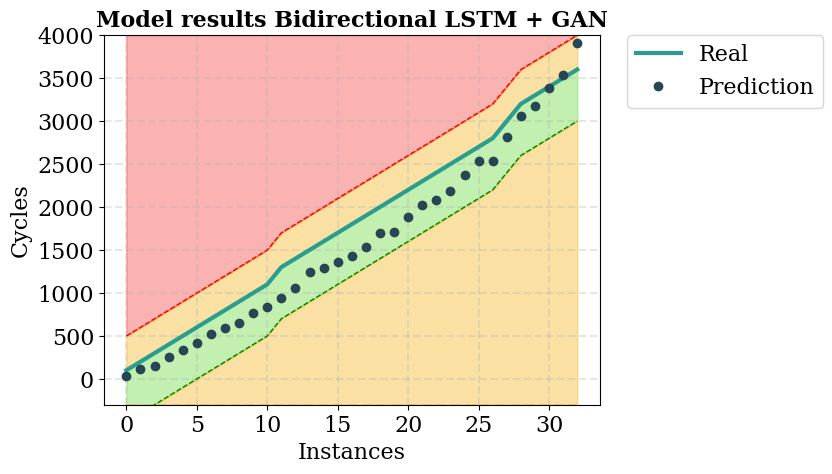

In [12]:
line_plot_result(ypred, y_test, ' Bidirectional LSTM + GAN')

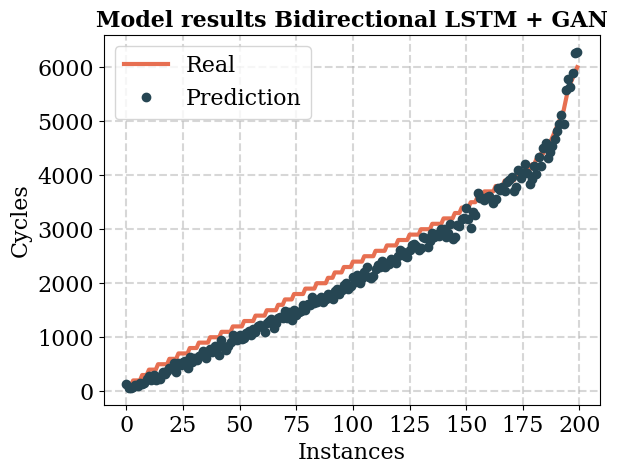

In [11]:
line_plot_result(ypred_train, y_train, ' Bidirectional LSTM + GAN')

In [26]:
differences = (y_test - ypred).flatten()
red_list, yellow_list, green_list = [], [], []
for k, v in enumerate(differences):
    df_modify = df_desc_final_pickle_load[df_desc_final_pickle_load.index.get_level_values(0) == 6]
    yellow = df_modify.head(1).RUL.values[0] - df_modify[df_modify['SoH_max_ch']>=81].tail(1).index.get_level_values(1)[0]
    red = df_modify.RUL.min() if len(df_modify[df_modify['SoH_max_ch']<70].head(1)) == 0 else df_modify[df_modify['SoH_max_ch']<70].head(1).RUL.values[0]
    if (v <= yellow) & (v >= 0): green_list.append(k)
    if (v <= red): red_list.append(k)
    if ((v > red) & (v < 0)) | (v > yellow) : yellow_list.append(k)
sum_list = len(red_list) + len(yellow_list) + len(green_list)
green, yellow, red = 100*(len(green_list)/sum_list), 100*len(yellow_list)/sum_list, 100*len(red_list)/sum_list
print('Green: ', green, 'Yellow: ', yellow, 'Red: ', red)

Green:  36.36363636363637 Yellow:  63.63636363636363 Red:  0.0
